In [1]:
!which jupyter
!which pip

/home/koosterb/miniconda3/bin/jupyter
/home/koosterb/miniconda3/bin/pip


In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import PIL

import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

import matplotlib.pyplot as plt
%matplotlib inline

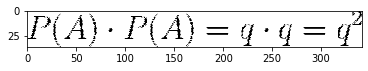

In [8]:
image_path = list(Path('/data/images/').rglob('*.png'))[100]
img = PIL.Image.open(image_path)
data = np.asarray(img)
plt.imshow(data, cmap='Greys')

In [29]:
image_dirname = Path('/data/images/')
data_generator = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.1,
)

In [30]:
dgen_args = {
    'directory': image_dirname,
    'target_size': (64, 128),
    'class_mode': 'sparse',
    'batch_size': 512,
    'shuffle': True,
    'color_mode': 'grayscale'
}

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

n_batches = len(train_dg)
trainX = []
for i in range(500):
    batch = train_dg.next()
    trainX.append(batch[0])
trainX = np.concatenate(trainX, axis=0)
data_generator.fit(trainX)

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

Found 506829 images belonging to 3 classes.
Found 56313 images belonging to 3 classes.
Found 506829 images belonging to 3 classes.
Found 56313 images belonging to 3 classes.


batch mean: 0.0023
batch std: 0.9980
batch shape: (512, 64, 128, 1)
Standard Normal: True


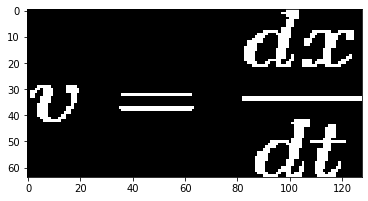

In [31]:
batch = train_dg.next()
X = batch[0]
print(f'batch mean: {X.mean():0.4f}')
print(f'batch std: {X.std():0.4f}')
print(f'batch shape: {X.shape}')
m, s = X.mean(), X.std()
print(f'Standard Normal: {(np.isclose(m,0, atol=0.1)) and (np.isclose(s, 1, atol=0.1))}')
plt.imshow(X[0, ..., 0], cmap='Greys')
plt.show()

In [43]:
def cv_model():
    input_shape = (64, 128, 1)
    input = layers.Input(shape=input_shape)
    tmp = input
    for i in range(5):
        #conv = layers.Conv2D(64*(2**i), 3, activation='relu', kernel_initializer='he_uniform', padding='same')(tmp)
        conv = layers.Conv2D(64*(2**i), 3, padding='same')(tmp)
        norm = layers.BatchNormalization()(conv)
        activ = layers.Activation('relu')(norm)
        pool = layers.MaxPooling2D(3, padding='same')(activ)
        tmp = pool
    flat = layers.Flatten()(tmp)
    for i in range(3):
        #flat = layers.Dense(256//(2**i), activation='relu', kernel_initializer='he_uniform')(flat)
        flat = layers.Dense(256//(2**i))(flat)
        norm = layers.BatchNormalization()(flat)
        activ = layers.Activation('relu')(norm)
        flat = activ
    output = layers.Dense(3, activation='softmax')(flat)
    model = models.Model(input, output)
    return model

def compile_model(model):
    opt = optimizers.Adam(0.01)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['sparse_categorical_accuracy']
    )
    return model

In [44]:
model = cv_model()
model = compile_model(model)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 128, 64)       640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128, 64)       256       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 128, 64)       0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 22, 43, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 22, 43, 128)       73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 22, 43, 128)       512 

In [45]:
history = model.fit_generator(
    train_dg,
    steps_per_epoch=len(train_dg),
    validation_data=val_dg,
    validation_steps=len(val_dg),
    epochs=24,
    shuffle=True
)

Epoch 1/24


/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site

990/990 [==============================] - 559s 565ms/step - loss: 0.3023 - sparse_categorical_accuracy: 0.9085 - val_loss: 0.3278 - val_sparse_categorical_accuracy: 0.9059
Epoch 2/24
990/990 [==============================] - 556s 562ms/step - loss: 0.2746 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.2973 - val_sparse_categorical_accuracy: 0.9136
Epoch 3/24
990/990 [==============================] - 559s 565ms/step - loss: 0.2605 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.2868 - val_sparse_categorical_accuracy: 0.9088
Epoch 4/24
990/990 [==============================] - 557s 562ms/step - loss: 0.2480 - sparse_categorical_accuracy: 0.9226 - val_loss: 0.2693 - val_sparse_categorical_accuracy: 0.9175
Epoch 5/24
990/990 [==============================] - 557s 562ms/step - loss: 0.2363 - sparse_categorical_accuracy: 0.9248 - val_loss: 0.2877 - val_sparse_categorical_accuracy: 0.9183
Epoch 6/24
990/990 [==============================] - 555s 560ms/step - loss: 0.2231 - spar

In [50]:
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')
    # save plot to file
    filename = "cv_first_try"
    plt.savefig(filename + '_plot.png')
    plt.show()
    plt.close()

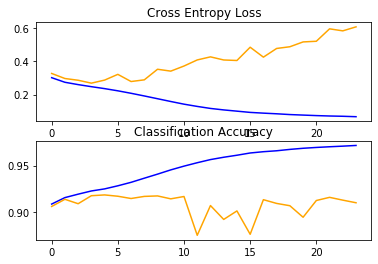

In [51]:
summarize_diagnostics(history)